In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/home/jerry/anaconda2/envs/tf35/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


38951745

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "/home/jerry/Projects/keras-oneshot" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train_landmark.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val_landmark.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys(['Mkhedruli_(Georgian)', 'Alphabet_of_the_Magi', 'Japanese_(katakana)', 'Burmese_(Myanmar)', 'Cyrillic', 'Greek', 'Armenian', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Balinese', 'Bengali', 'Asomtavruli_(Georgian)', 'Braille', 'Tifinagh', 'Futurama', 'Tagalog', 'Malay_(Jawi_-_Arabic)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Korean', 'N_Ko', 'Gujarati', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Anglo-Saxon_Futhorc', 'Latin', 'Arcadian', 'Early_Aramaic', 'Hebrew', 'Syriac_(Estrangelo)'])
validation alphabets:
dict_keys(['Syriac_(Serto)', 'Avesta', 'Glagolitic', 'Keble', 'Aurek-Besh', 'Old_Church_Slavonic_(Cyrillic)', 'Tengwar', 'Malayalam', 'Angelic', 'Mongolian', 'Tibetan', 'Kannada', 'Ge_ez', 'Atlantean', 'Manipuri', 'Oriya', 'ULOG', 'Sylheti', 'Atemayar_Qelisayer', 'Gurmukhi'])


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/jerry/Projects/keras-oneshot/train.pickle
loading data from /home/jerry/Projects/keras-oneshot/val.pickle


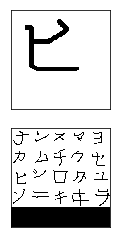

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [ ]:

#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
4.51718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 8.0% 20 way one-shot learning accuracy
saving
4.47316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 20.4% 20 way one-shot learning accuracy
saving
4.45666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.6% 20 way one-shot learning accuracy
saving
4.42896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 33.2% 20 way one-shot learning accuracy
saving
4.43113
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 29.2% 20 way one-shot learning accuracy
4.38871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 25.2% 20 way one-shot learning accuracy
4.35231
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 3

Got an average of 22.8% 20 way one-shot learning accuracy
3.49653
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 22.8% 20 way one-shot learning accuracy
3.56683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 22.0% 20 way one-shot learning accuracy
3.55398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.6% 20 way one-shot learning accuracy
3.64672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 19.6% 20 way one-shot learning accuracy
3.58461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 21.6% 20 way one-shot learning accuracy
3.52356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 29.6% 20 way one-shot learning accuracy
3.42819
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 27.2% 20 way one-shot learning accuracy
3.06204
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.0% 20 way one-shot learning accuracy
3.02941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 24.4% 20 way one-shot learning accuracy
3.0403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.4% 20 way one-shot learning accuracy
3.0866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 25.6% 20 way one-shot learning accuracy
3.10873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.0% 20 way one-shot learning accuracy
3.00169
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.2% 20 way one-shot learning accuracy
3.06067
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 31.6% 20 way one-shot learning accuracy
2.68449
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.6% 20 way one-shot learning accuracy
2.635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.8% 20 way one-shot learning accuracy
2.70265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.0% 20 way one-shot learning accuracy
2.56723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.0% 20 way one-shot learning accuracy
2.54476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.8% 20 way one-shot learning accuracy
2.75118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 30.8% 20 way one-shot learning accuracy
2.59694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 27.2% 20 way one-shot learning accuracy
2.4212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.4% 20 way one-shot learning accuracy
2.53273
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.4% 20 way one-shot learning accuracy
2.3582
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 29.6% 20 way one-shot learning accuracy
2.29939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.8% 20 way one-shot learning accuracy
2.38615
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 29.6% 20 way one-shot learning accuracy
2.28924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 31.2% 20 way one-shot learning accuracy
2.33464
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 31.2% 20 way one-shot learning accuracy
2.15755
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.8% 20 way one-shot learning accuracy
2.064
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 38.4% 20 way one-shot learning accuracy
2.12947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 34.4% 20 way one-shot learning accuracy
2.19322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 38.4% 20 way one-shot learning accuracy
2.09831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 36.0% 20 way one-shot learning accuracy
2.23189
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.8% 20 way one-shot learning accuracy
2.12712
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 42.4% 20 way one-shot learning accuracy
2.02828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.0% 20 way one-shot learning accuracy
2.01782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.6% 20 way one-shot learning accuracy
2.09063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 42.4% 20 way one-shot learning accuracy
2.12136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 32.0% 20 way one-shot learning accuracy
2.01977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 33.2% 20 way one-shot learning accuracy
iteration 350, training loss: 2.02,
1.83059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 38.8% 20 way one-shot learning accuracy
1.94486
evaluating
Evaluating model on 250 rando

Got an average of 44.8% 20 way one-shot learning accuracy
1.8628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 41.2% 20 way one-shot learning accuracy
1.77521
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
1.8585
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.4% 20 way one-shot learning accuracy
1.78269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.8% 20 way one-shot learning accuracy
1.6631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.8% 20 way one-shot learning accuracy
1.81667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.2% 20 way one-shot learning accuracy
1.70957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Go

Got an average of 49.6% 20 way one-shot learning accuracy
1.77874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.6% 20 way one-shot learning accuracy
1.72819
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
1.81294
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.4% 20 way one-shot learning accuracy
1.79458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
1.7414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.2% 20 way one-shot learning accuracy
1.83419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.0% 20 way one-shot learning accuracy
1.71683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...


Got an average of 59.2% 20 way one-shot learning accuracy
saving
1.49654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 49.6% 20 way one-shot learning accuracy
1.62905
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.4% 20 way one-shot learning accuracy
1.65636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.4% 20 way one-shot learning accuracy
1.78793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.4% 20 way one-shot learning accuracy
1.60514
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.2% 20 way one-shot learning accuracy
1.63237
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 49.6% 20 way one-shot learning accuracy
1.59919
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 50.0% 20 way one-shot learning accuracy
1.63299
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
1.54629
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.6% 20 way one-shot learning accuracy
1.59761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.0% 20 way one-shot learning accuracy
1.70575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
1.63957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
1.48029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.4% 20 way one-shot learning accuracy
1.52579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 56.8% 20 way one-shot learning accuracy
1.33065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
1.49463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
1.53391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
1.2919
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.0% 20 way one-shot learning accuracy
1.41224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.8% 20 way one-shot learning accuracy
1.47218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.4% 20 way one-shot learning accuracy
1.29651
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...


Got an average of 52.8% 20 way one-shot learning accuracy
1.38692
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
1.32267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
1.58473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 49.6% 20 way one-shot learning accuracy
1.50269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.0% 20 way one-shot learning accuracy
1.48495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 39.2% 20 way one-shot learning accuracy
1.33135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
1.36846
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 54.0% 20 way one-shot learning accuracy
1.28099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
1.32535
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
1.28385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.6% 20 way one-shot learning accuracy
1.3481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.2% 20 way one-shot learning accuracy
iteration 750, training loss: 1.35,
1.38666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.8% 20 way one-shot learning accuracy
1.52151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
1.16884
evaluating
Evaluating model on 250 random

Got an average of 52.4% 20 way one-shot learning accuracy
1.31779
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
1.15206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
1.12121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
1.24412
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
1.23306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
1.32087
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
1.18036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 60.4% 20 way one-shot learning accuracy
1.14411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
1.23675
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
1.17198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.2% 20 way one-shot learning accuracy
1.27398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
1.21518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
1.14591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.0% 20 way one-shot learning accuracy
1.31691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 57.6% 20 way one-shot learning accuracy
1.10018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
1.11168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
1.12551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
1.29641
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
1.18725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
1.29206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
1.14761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 60.0% 20 way one-shot learning accuracy
1.07329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
1.2987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
1.12569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
1.0513
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
1.03051
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
1.17278
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
1.05282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 58.8% 20 way one-shot learning accuracy
1.08457
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
1.04901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
1.06309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
1.22107
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
0.973572
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
0.979415
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
1.0716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ..

Got an average of 56.8% 20 way one-shot learning accuracy
1.05153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.8% 20 way one-shot learning accuracy
0.983461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
1.05589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
1.01443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
1.01982
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
0.948789
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
0.986003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks 

Got an average of 56.0% 20 way one-shot learning accuracy
0.891607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
1.05523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.924672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1150, training loss: 0.92,
1.11822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
1.00308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
0.966552
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
1.17277
evaluating
Evaluating model on 250 r

Got an average of 55.2% 20 way one-shot learning accuracy
0.890396
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
1.17646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
1.07474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
0.933399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
0.998036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
0.966128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
1.01377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 65.6% 20 way one-shot learning accuracy
0.895546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
0.853474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
1.05119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
0.857938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
0.932917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
1.11331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
0.839134
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 59.2% 20 way one-shot learning accuracy
0.887573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
0.841395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
0.927985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
1.02413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.816818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
0.996907
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
1.05172
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 66.8% 20 way one-shot learning accuracy
0.831007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.790271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
0.798054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
0.906493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
0.904009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
0.899332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
0.907485
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 64.8% 20 way one-shot learning accuracy
0.79804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.831958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
0.847374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
0.820192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
0.887454
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.837754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.967646
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 67.2% 20 way one-shot learning accuracy
0.792342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.886743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.796235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
0.860153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
0.760077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
0.807512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
1.15375
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 67.6% 20 way one-shot learning accuracy
0.859305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
0.705705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
0.835262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
0.780123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1550, training loss: 0.78,
0.770931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.865036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
0.813144
evaluating
Evaluating model on 2

Got an average of 63.2% 20 way one-shot learning accuracy
0.701224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.721333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.880632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.748668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.714134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.74769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
saving
0.720535
evaluating
Evaluating model on 250 random 20 way one-shot learn

Got an average of 58.0% 20 way one-shot learning accuracy
0.800627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
0.733144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.862563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.652956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.677025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.700259
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.766903
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 65.2% 20 way one-shot learning accuracy
0.684797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.894717
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.800343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.708481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.63872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.659326
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.679327
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 62.4% 20 way one-shot learning accuracy
0.759247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
saving
0.710976
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
0.72616
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
0.757711
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
0.781509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
0.625461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
0.722972
evaluating
Evaluating model on 250 random 20 way one-shot learn

Got an average of 63.6% 20 way one-shot learning accuracy
0.657967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
0.699975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.671411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
1.0018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.69227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
0.667171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.681867
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 66.8% 20 way one-shot learning accuracy
0.585931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.824475
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.600832
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.593297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
0.729447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.759591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.758435
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 66.4% 20 way one-shot learning accuracy
0.654595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
0.677786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
0.695203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.606782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.679858
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 1950, training loss: 0.68,
0.643064
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.834415
evaluating
Evaluating model on 2

Got an average of 65.6% 20 way one-shot learning accuracy
0.587682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.591569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.636646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.539829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.651636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.605545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.560577
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 59.6% 20 way one-shot learning accuracy
0.811492
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
0.620894
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.567499
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.54863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.667367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
0.626121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.579121
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 66.0% 20 way one-shot learning accuracy
0.612894
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.661557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.645083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.558917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.631834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
0.660323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.575836
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 64.8% 20 way one-shot learning accuracy
0.525025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
0.60589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.717056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.630667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.611811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.671843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.666735
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 67.2% 20 way one-shot learning accuracy
0.542798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.521553
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.576119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.661856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.835077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.471756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.572569
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 59.6% 20 way one-shot learning accuracy
0.582264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.675578
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
0.569125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
0.571337
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
0.60103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.585694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.550183
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 68.0% 20 way one-shot learning accuracy
0.625256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.586879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.605234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.696795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.622305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.739667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 2350, training loss: 0.74,
0.556184
evaluating
Evaluating model on 2

Got an average of 60.0% 20 way one-shot learning accuracy
0.4761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
0.510777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.498858
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.653889
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.589607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.64949
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.621548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 69.2% 20 way one-shot learning accuracy
0.586245
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
0.511115
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
0.687051
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
0.524714
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.558959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.476329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.537582
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 67.2% 20 way one-shot learning accuracy
0.604268
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.54833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.600455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
0.755929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.506707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.546391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.711089
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 74.0% 20 way one-shot learning accuracy
0.550039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.548917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.562026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.582092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.554171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.526417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
0.505877
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 72.4% 20 way one-shot learning accuracy
0.467462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.472248
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.6878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.51005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.482803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.490322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.517132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 67.6% 20 way one-shot learning accuracy
0.507771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.495801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
0.490588
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.553486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.703781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.552637
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.572978
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 70.8% 20 way one-shot learning accuracy
0.4734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.473382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.450785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.451295
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
0.403888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.522638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.567723
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 2800, training loss: 0.43,
0.444082
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
0.486461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
0.452515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.755305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.48719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.467291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.589532
evaluating
Evaluating model on 25

Got an average of 67.6% 20 way one-shot learning accuracy
0.510387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.561581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.451524
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.444947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.478655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.534761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.683066
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 65.2% 20 way one-shot learning accuracy
0.48458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.486144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.626522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.58176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.539635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.537546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.447469
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 66.8% 20 way one-shot learning accuracy
0.555285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
0.424086
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.477958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
0.447842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.519605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
0.465007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.544394
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 66.0% 20 way one-shot learning accuracy
0.481747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
0.451888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.465123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.465932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
0.481427
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.496482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.390757
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 68.8% 20 way one-shot learning accuracy
0.403706
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.606983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.53591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
0.607712
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
0.528451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
0.455863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.405997
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 70.0% 20 way one-shot learning accuracy
0.566402
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.538277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.404994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.672732
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.546221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.472423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.493638
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 75.2% 20 way one-shot learning accuracy
0.409845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 3200, training loss: 0.41,
0.489563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.418747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.530899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
0.407421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.412435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.480185
evaluating
Evaluating model on 2

Got an average of 70.4% 20 way one-shot learning accuracy
0.497144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.385008
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.450309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
0.418251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.550478
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
0.559821
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
0.416844
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 67.2% 20 way one-shot learning accuracy
0.38342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
0.458819
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
0.468203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.396571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
0.363473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
0.370677
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.478711
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 69.2% 20 way one-shot learning accuracy
0.458847
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.433266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.486297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.404528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.366515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.42199
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.453898
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 69.2% 20 way one-shot learning accuracy
0.415469
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.433111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.453859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
0.541681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.516142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.597969
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.436086
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 70.4% 20 way one-shot learning accuracy
0.402448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.434093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
0.46285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
0.407891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.395952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.381368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
0.350858
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 68.8% 20 way one-shot learning accuracy
0.460761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
0.468691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.652459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.535983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.440802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
0.408023
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
0.410869
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 72.4% 20 way one-shot learning accuracy
0.356397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
0.402322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 3600, training loss: 0.40,
0.39417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
0.337249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
0.505388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.417446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.595113
evaluating
Evaluating model on 25

Got an average of 78.4% 20 way one-shot learning accuracy
0.523299
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
0.491169
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
0.451784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
0.375109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.423504
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
0.34705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.724823
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 74.8% 20 way one-shot learning accuracy
0.376655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.479667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.354097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
0.493955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.477346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.380856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.4382
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 70.8% 20 way one-shot learning accuracy
0.455165
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.476281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.433502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.375103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.384014
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.451681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
0.329612
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 72.8% 20 way one-shot learning accuracy
0.416052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.380668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.336322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.547028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.343128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.35936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.327947
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 69.6% 20 way one-shot learning accuracy
0.40411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
0.387426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.494301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
0.476682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
0.612808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.460541
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
0.355101
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 68.8% 20 way one-shot learning accuracy
0.344951
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.47324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.432119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.513726
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.399085
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.431479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
0.386557
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 72.0% 20 way one-shot learning accuracy
0.367745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
0.302293
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.353841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4000, training loss: 0.35,
0.354209
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.422005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.34437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
0.404395
evaluating
Evaluating model on 25

Got an average of 72.4% 20 way one-shot learning accuracy
0.296522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
0.318139
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
0.374003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
0.432018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.531315
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.450786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
0.36654
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 71.6% 20 way one-shot learning accuracy
0.345086
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
0.331123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.348566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
0.319133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
0.465859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
0.39959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.360316
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 72.8% 20 way one-shot learning accuracy
0.413656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
0.674127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.376277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
0.321112
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
0.530214
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
0.32691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
0.370208
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)